In [56]:
import pandas as pd
import numpy as np
import ast 

import nltk
from nltk import word_tokenize, download
from nltk.corpus import stopwords

from gensim import models
from gensim.corpora import Dictionary, MmCorpus

import pickle

In [57]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adrienawong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adrienawong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [58]:
def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('english'))

In [59]:
def prep_corpus(docs, additional_stopwords=set(), no_below=1, no_above=0.5):
    print('Building dictionary...')
    dictionary = Dictionary(docs)
    stopwords = nltk_stopwords().union(additional_stopwords)
    stopword_ids = map(dictionary.token2id.get, stopwords)
    dictionary.filter_tokens(stopword_ids)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()

    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus

In [60]:
num_topics = 10

### With the Kaggle dataset

In [61]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [62]:
def preprocess_wiki(comment):
    comment = word_tokenize(comment)  # Split into words.
    for c in comment:
        if '\n' in c:
            c = c.replace('\n', '')
    comment = [w for w in comment if not w in stop_words]  # Remove stopwords.
    comment = [w for w in comment if w.isalpha()]  # Remove numbers and punctuation.
    return comment

In [63]:
df['comment_text'] = df['comment_text'].fillna('fillna').str.lower()
df['text_tokens'] = df['comment_text'].apply(preprocess_wiki)
df['text_tokens']

0         [explanation, edits, made, username, hardcore,...
1         [matches, background, colour, seemingly, stuck...
2         [hey, man, really, trying, edit, war, guy, con...
3         [ca, make, real, suggestions, improvement, won...
4                       [sir, hero, chance, remember, page]
                                ...                        
159566    [second, time, asking, view, completely, contr...
159567          [ashamed, horrible, thing, put, talk, page]
159568    [spitzer, umm, theres, actual, article, prosti...
159569    [looks, like, actually, put, speedy, first, ve...
159570    [really, think, understand, came, idea, bad, r...
Name: text_tokens, Length: 159571, dtype: object

In [64]:
dictionary_wiki, corpus_wiki = prep_corpus(df['text_tokens'])
lda_wiki = models.ldamodel.LdaModel(corpus=corpus_wiki, id2word=dictionary_wiki, num_topics=num_topics, passes=50)

Building dictionary...
Building corpus...


In [65]:
file = open('lda_wiki.pkl', 'wb')
pickle.dump(lda_wiki, file)
file.close()

file = open('dictionary_wiki.pkl', 'wb')
pickle.dump(dictionary_wiki, file)
file.close()

In [66]:
# Reading dictionary and model files:

# with open('lda_wiki.pkl', 'rb') as f:
#     lda_wiki = pickle.load(f)
# with open('dictionary_wiki.pkl', 'rb') as f:
#     dictionary_wiki = pickle.load(f)

In [67]:
mm = [dictionary_wiki.doc2bow(text) for text in df['text_tokens']]
topics = pd.DataFrame(dict(lda_wiki[x]) for x in mm)
df['topics'] = topics.values.tolist()

In [68]:
#Write to CSV
print('Writing to CSV')
df.to_csv("topic_modelling_wiki.csv")

Writing to CSV


In [69]:
lda_wiki.show_topics(formatted=False)

[(0,
  [('name', 0.009151527),
   ('english', 0.00789941),
   ('also', 0.007651099),
   ('used', 0.0076259878),
   ('people', 0.0065378677),
   ('use', 0.006420261),
   ('term', 0.0064027687),
   ('one', 0.0062033497),
   ('language', 0.0056375144),
   ('war', 0.0054206587)]),
 (1,
  [('http', 0.0132758375),
   ('school', 0.006162523),
   ('book', 0.005963821),
   ('new', 0.005795462),
   ('years', 0.0050813383),
   ('also', 0.0048469934),
   ('film', 0.003999251),
   ('john', 0.0037370434),
   ('world', 0.0036332747),
   ('news', 0.003561841)]),
 (2,
  [('like', 0.014658994),
   ('know', 0.0127532985),
   ('would', 0.011814861),
   ('one', 0.011259656),
   ('think', 0.010837668),
   ('get', 0.009209723),
   ('time', 0.009128412),
   ('people', 0.009063477),
   ('article', 0.007329005),
   ('good', 0.0072916797)]),
 (3,
  [('article', 0.038958684),
   ('deletion', 0.03063705),
   ('image', 0.028583795),
   ('page', 0.026997186),
   ('wikipedia', 0.024237618),
   ('please', 0.02270613),

### With the Twitter dataset

In [70]:
twitter_df = pd.read_csv('../data/sample_with_label.csv')
twitter_df.head()

,Unnamed: 0,TweetID,UserName,TweetText,TweetDateTime,Followers,UserID,WasDeleted
0,0,1244721273793646594,ShannePanne,b'Rhoa',2020-03-30 20:20:52,287,990004076829200385,0
1,1,1244721275232301058,25_ShadesOfK,b'@HisTemp_TAYtion Lol I learned from that shi...,2020-03-30 20:20:52,1189,624244930,0
2,2,1244721275936878593,PlagueJesterSky,b'Trying to set up the stream and I keep getti...,2020-03-30 20:20:52,415,755613447702847488,0
3,3,1244721278650650624,spitbull1963,b'@EricksonReal @Ilhan And you can test as muc...,2020-03-30 20:20:53,16,47425986,0
4,4,1244721278931664896,kamanfrancis,b'Me taking notes for the future when I\xe2\x8...,2020-03-30 20:20:53,1928,269295980,0


In [71]:
def preprocess_twitter(comment):
    comment = word_tokenize(comment)  # Split into words.
    for c in comment:
        if '\'b' in c:
            c = c.replace('\'b', '')
        if '\\x' in c:
            c = c.replace('\\x', ' \\x')
    comment = [w for w in comment if not w in stop_words]  # Remove stopwords.
    comment = [w for w in comment if w.isalpha()]  # Remove numbers and punctuation.
    return comment

In [72]:
twitter_df['TweetText'] = twitter_df['TweetText'].fillna('fillna').str.lower()
twitter_df['text_tokens'] = twitter_df['TweetText'].apply(preprocess_twitter)
twitter_df['text_tokens']

0                                                        []
1         [b, lol, learned, shit, putting, eggs, one, ba...
2         [set, stream, keep, getting, error, code, come...
3         [b, ericksonreal, ilhan, test, much, like, fuc...
4         [taking, notes, future, rush, got, ta, daughte...
                                ...                        
404143    [b, give, single, fuck, want, want, serve, sen...
404144    [tweet, reminding, wash, hands, stay, cute, uw...
404145                                          [fuck, die]
404146    [b, en, mi, caso, de, los, que, juego, para, e...
404147                                         [b, qzeraus]
Name: text_tokens, Length: 404148, dtype: object

In [73]:
dictionary_twitter, corpus_twitter = prep_corpus(twitter_df['text_tokens'])
lda_twitter = models.ldamodel.LdaModel(corpus=corpus_twitter, id2word=dictionary_twitter, num_topics=num_topics, passes=50)

Building dictionary...
Building corpus...


In [74]:
file = open('lda_twitter.pkl', 'wb')
pickle.dump(lda_twitter, file)
file.close()

file = open('dictionary_twitter.pkl', 'wb')
pickle.dump(dictionary_twitter, file)
file.close()

In [75]:
# Reading dictionary and model files:

# with open('lda_twitter.pkl', 'rb') as f:
#     lda_twitter = pickle.load(f)
# with open('dictionary_twitter.pkl', 'rb') as f:
#     dictionary_twitter = pickle.load(f)

In [76]:
mm = [dictionary_twitter.doc2bow(text) for text in twitter_df['text_tokens']]
topics = pd.DataFrame(dict(lda_twitter[x]) for x in mm)
twitter_df['topics'] = topics.values.tolist()

In [77]:
#Write to CSV
print('Writing to CSV')
twitter_df.to_csv("topic_modelling_twitter.csv")

Writing to CSV


In [78]:
lda_twitter.show_topics(formatted=False)

[(0,
  [('yes', 0.01775655),
   ('old', 0.01381106),
   ('said', 0.012664417),
   ('year', 0.012536691),
   ('week', 0.012468138),
   ('wish', 0.011021786),
   ('seen', 0.010270801),
   ('though', 0.0096722515),
   ('bullshit', 0.0094514275),
   ('night', 0.009295085)]),
 (1,
  [('fuck', 0.19156133),
   ('bitch', 0.045365296),
   ('na', 0.04443226),
   ('ass', 0.025740797),
   ('https', 0.024740443),
   ('gon', 0.022270177),
   ('wan', 0.019444875),
   ('want', 0.013731251),
   ('shut', 0.011667606),
   ('yeah', 0.010558286)]),
 (2,
  [('fuck', 0.07449539),
   ('people', 0.023647208),
   ('fucking', 0.021588784),
   ('shit', 0.017120857),
   ('kill', 0.013069377),
   ('realdonaldtrump', 0.012250862),
   ('die', 0.012225365),
   ('us', 0.009597877),
   ('trump', 0.009409304),
   ('shut', 0.008846247)]),
 (3,
  [('need', 0.017069716),
   ('us', 0.013301801),
   ('time', 0.012651318),
   ('amp', 0.011998255),
   ('get', 0.0118516395),
   ('day', 0.011486981),
   ('help', 0.009994743),
   

## Topic Distribution Analysis

In [83]:
df = pd.read_csv('topic_modelling_twitter.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,TweetID,UserName,TweetText,TweetDateTime,Followers,UserID,WasDeleted,text_tokens,topics
0,0,0,1244721273793646594,ShannePanne,b'rhoa',2020-03-30 20:20:52,287,990004076829200385,0,[],"[0.10000000149011612, 0.10000000149011612, 0.1..."
1,1,1,1244721275232301058,25_ShadesOfK,b'@histemp_taytion lol i learned from that shi...,2020-03-30 20:20:52,1189,624244930,0,"['b', 'lol', 'learned', 'shit', 'putting', 'eg...","[nan, nan, nan, 0.1247185692191124, nan, 0.108..."
2,2,2,1244721275936878593,PlagueJesterSky,b'trying to set up the stream and i keep getti...,2020-03-30 20:20:52,415,755613447702847488,0,"['set', 'stream', 'keep', 'getting', 'error', ...","[0.07852327823638916, nan, nan, nan, 0.1525963..."
3,3,3,1244721278650650624,spitbull1963,b'@ericksonreal @ilhan and you can test as muc...,2020-03-30 20:20:53,16,47425986,0,"['b', 'ericksonreal', 'ilhan', 'test', 'much',...","[nan, nan, 0.32516738772392273, 0.130947604775..."
4,4,4,1244721278931664896,kamanfrancis,b'me taking notes for the future when i\xe2\x8...,2020-03-30 20:20:53,1928,269295980,0,"['taking', 'notes', 'future', 'rush', 'got', '...","[0.011127191595733166, 0.011127191595733166, 0..."


In [84]:
def to_clean_list(x):
    x = x.replace('nan', '0')
    return ast.literal_eval(x)

In [85]:
df['topics'] = df['topics'].apply(to_clean_list)
topic_list = []
for i in range(1, num_topics+1):
    topic_list.append('topic_' + str(i))
df[topic_list] = pd.DataFrame(df['topics'].values.tolist())


In [86]:
all_topic_dist = np.average(df['topics'].tolist(), axis = 0)
all_topic_dist

array([0.05720864, 0.11920666, 0.10003559, 0.09439033, 0.07480969,
       0.09488788, 0.13446399, 0.21146122, 0.0526946 , 0.0493169 ])

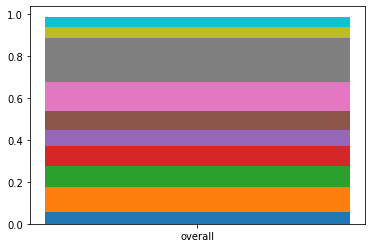

In [87]:
import matplotlib.pyplot as plt

running_sum = 0
for i in range(num_topics):
    plt.bar('overall', all_topic_dist[i], bottom = running_sum)
    running_sum = running_sum + all_topic_dist[i]
    

In [88]:
df_grouped = df[['WasDeleted'] + topic_list].groupby(['WasDeleted']).mean()
df_grouped

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
WasDeleted,,,,,,,,,,
0,0.057554,0.114958,0.099950,0.095204,0.075274,0.097241,0.137641,0.210077,0.052109,0.048587
1,0.054446,0.153209,0.100717,0.087875,0.071096,0.076061,0.109039,0.222540,0.057381,0.055157


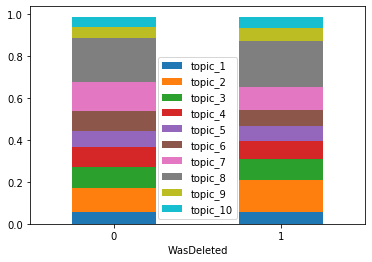

In [89]:
df_grouped.plot(kind = 'bar', stacked = True, rot = 0)

In [128]:
#do a significance test; null hypothesis is that 
import scipy
scipy.stats.chisquare(df_grouped.iloc[0], df_grouped.iloc[1])


Power_divergenceResult(statistic=0.025955720699377783, pvalue=0.9999999999389133)

### Vocab size

In [91]:
len(dictionary_twitter)

208782

In [92]:
len(dictionary_wiki)

157319

In [95]:
df_grouped.iloc[0]

topic_1     0.057554
topic_2     0.114958
topic_3     0.099950
topic_4     0.095204
topic_5     0.075274
topic_6     0.097241
topic_7     0.137641
topic_8     0.210077
topic_9     0.052109
topic_10    0.048587
Name: 0, dtype: float64

In [101]:
df_grouped.iloc[0,0]

0.05755382838749242

In [105]:
len(df)

404148